In [1]:
import requests
from pyspark.sql import SparkSession
from pyspark.sql import DataFrameReader
from urllib.request import urlopen
from pymongo import MongoClient
import pymongo
import pandas as pd
import os

In [2]:
def data_into_mongo(location, client):
    days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    start_date = "2010-01-01"
    db = client['Real_Time_Weather']
    col = db[location]
    
    for year in [2019, 2020, 2021]:
        j = 1
        for i in days:
            start_date = "{}-{}-01".format(year,j)
            end_date = "{}-{}-{}".format(year,j,i)
            j += 1
            
            url = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=6052652525c04c6b88b74541222512&q={}&format=json&date={}&enddate={}&includelocation=yes&tp=24".format(location, start_date, end_date)
            response = requests.request("GET", url)
            data = response.json()
            for k in data["data"]["weather"]:
                col.insert_one(k)

In [7]:
payload={}
headers = {}

client = MongoClient("mongodb://localhost:27017/")        
db = client['Real_Time_Weather']
collection = db["sample"]
loc = input("Enter the location: ")
try:
    if (db.validate_collection(f"{loc}")):  # Try to validate a collection
        print("Collection exists")
        
except pymongo.errors.OperationFailure:  # If the collection doesn't exist
    print("Collecting History Data")
    data_into_mongo(loc, client)

Collection exists


In [8]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars file:///C:/Users/Ansuman/Desktop/MiniProject/mongo-spark-connector_2.12-3.0.1-assembly.jar pyspark-shell'

spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/") \
    .config("spark.mongodb.output.collection", collection) \
    .getOrCreate()
    


In [9]:
def retrieve_data_from_mongo(spark):
    df = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri", "mongodb://localhost:27017/Real_Time_Weather.{}".format(loc)).load()
    
    df = df.drop("_id")
    
    hourly_data = df.select("date","hourly.tempC","hourly.windspeedKmph", "hourly.precipMM", "hourly.humidity", "hourly.pressure").toPandas()
    
    return hourly_data
    

In [10]:
data_pdf = retrieve_data_from_mongo(spark)

In [12]:
data_pdf.head()

,date,tempC,windspeedKmph,precipMM,humidity,pressure
0,2019-01-01,[1],[12],[6.1],[75],[1017]
1,2019-01-02,[-1],[7],[1.3],[69],[1023]
2,2019-01-03,[0],[12],[2.0],[76],[1015]
3,2019-01-04,[5],[17],[0.0],[77],[1009]
4,2019-01-05,[4],[12],[0.0],[86],[1007]


In [25]:
from prophet import Prophet

In [26]:
def preprocess_data(data_pdf):
    data_pdf["Temp"] = data_pdf["tempC"].apply(pd.Series)
    data_pdf["Rain"] = data_pdf["precipMM"].apply(pd.Series)
    data_pdf["Humidity"] = data_pdf["humidity"].apply(pd.Series)
    data_pdf["WindSpeed"] = data_pdf["windspeedKmph"].apply(pd.Series)
    data_pdf["Pressure"] = data_pdf["pressure"].apply(pd.Series)
    
    data_pdf = data_pdf.drop(['tempC', 'precipMM', "humidity","windspeedKmph", "pressure"], axis=1)
    
    convert_dict = {'Temp': int,
                'Rain': float,
                'Humidity':int,
                'WindSpeed': int,
                'Pressure': int
                }
    data_pdf = data_pdf.astype(convert_dict)
    data_pdf['date'] = pd.DatetimeIndex(data_pdf['date'])
    
    return data_pdf
    

In [27]:
data_df = preprocess_data(data_pdf)

In [28]:
data_df.head()

,date,Temp,Rain,Humidity,WindSpeed,Pressure
0,2019-01-01,1,6.1,75,12,1017
1,2019-01-02,-1,1.3,69,7,1023
2,2019-01-03,0,2.0,76,12,1015
3,2019-01-04,5,0.0,77,17,1009
4,2019-01-05,4,0.0,86,12,1007


In [29]:
data_df.dtypes

date         datetime64[ns]
Temp                  int32
Rain                float64
Humidity              int32
WindSpeed             int32
Pressure              int32
dtype: object

In [30]:
df = data_df[["date",'Temp']]

In [31]:
df = df.rename(columns={'date': 'ds',
                        'Temp': 'y'})

In [32]:
df.dtypes

ds    datetime64[ns]
y              int32
dtype: object

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

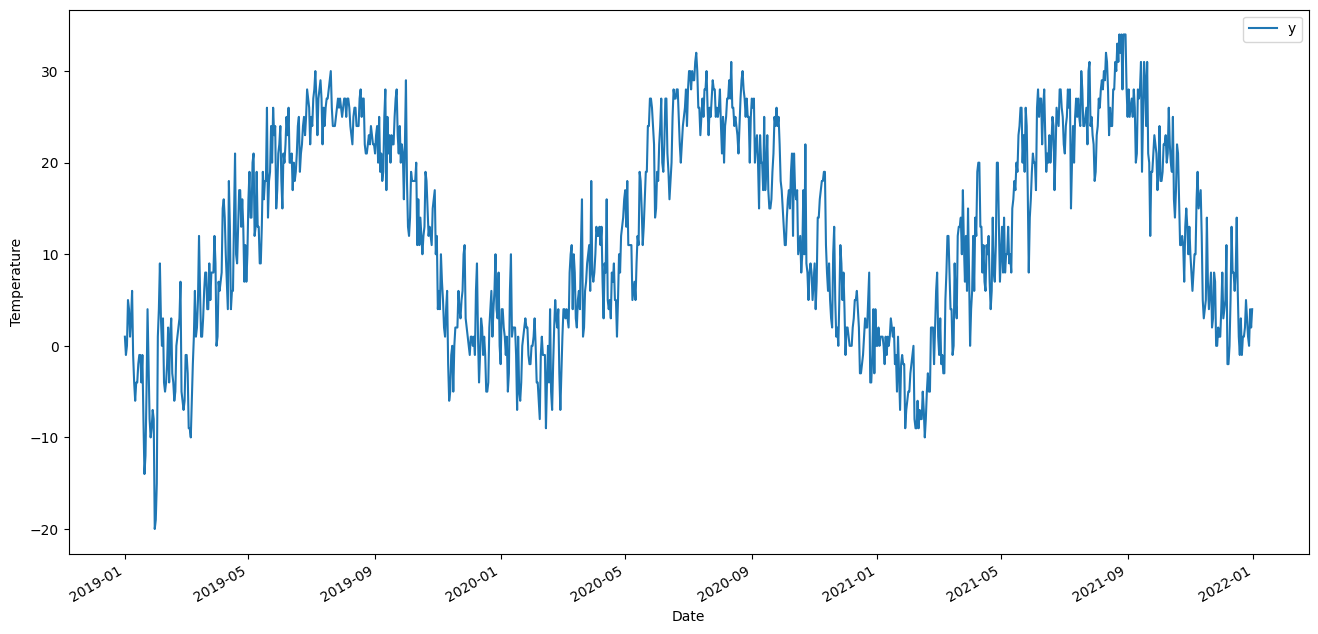

In [34]:
ax = df.set_index('ds').plot(figsize=(16, 8))
ax.set_ylabel('Temperature')
ax.set_xlabel('Date')

plt.show()

In [35]:
prophet_model= Prophet(interval_width=0.90)

In [36]:
prophet_model.fit(df)

00:28:41 - cmdstanpy - INFO - Chain [1] start processing
00:28:41 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
future_dates = prophet_model.make_future_dataframe(periods=10, freq='MS')

In [38]:
forecast = prophet_model.predict(future_dates)

In [39]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-01,0.826917,-6.108352,7.484759
1,2019-01-02,1.028757,-5.283416,7.685989
2,2019-01-03,0.751441,-5.899473,7.829195
3,2019-01-04,0.491669,-6.038765,7.300040
4,2019-01-05,0.159232,-6.583719,7.083976
...,...,...,...,...
1100,2022-06-01,24.330739,17.605218,30.894212
1101,2022-07-01,28.128565,21.533051,34.968666
1102,2022-08-01,27.894999,20.919668,34.857911
1103,2022-09-01,27.666444,20.844711,34.688877


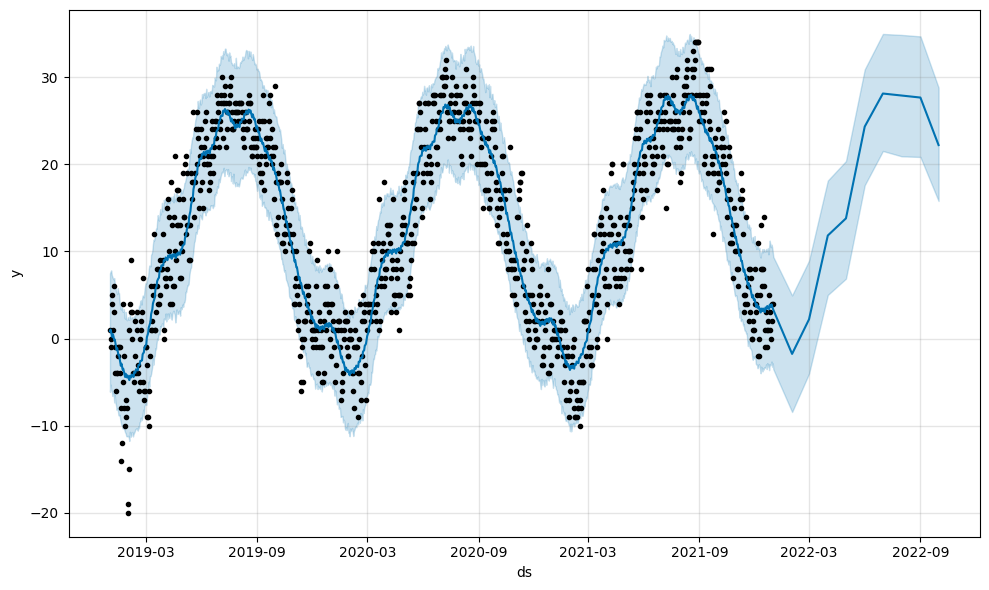

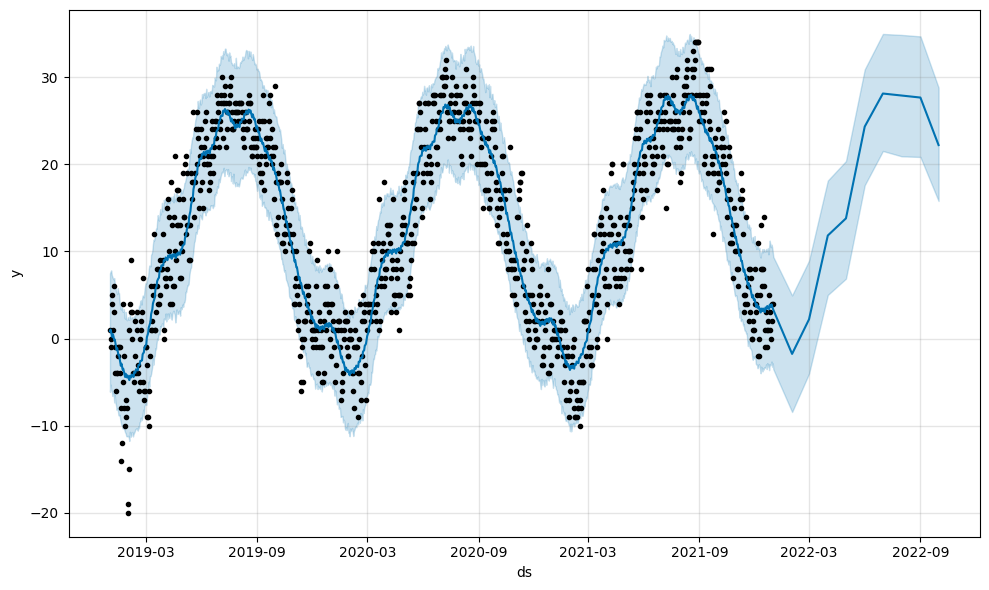

In [40]:
prophet_model.plot(forecast, uncertainty=True)

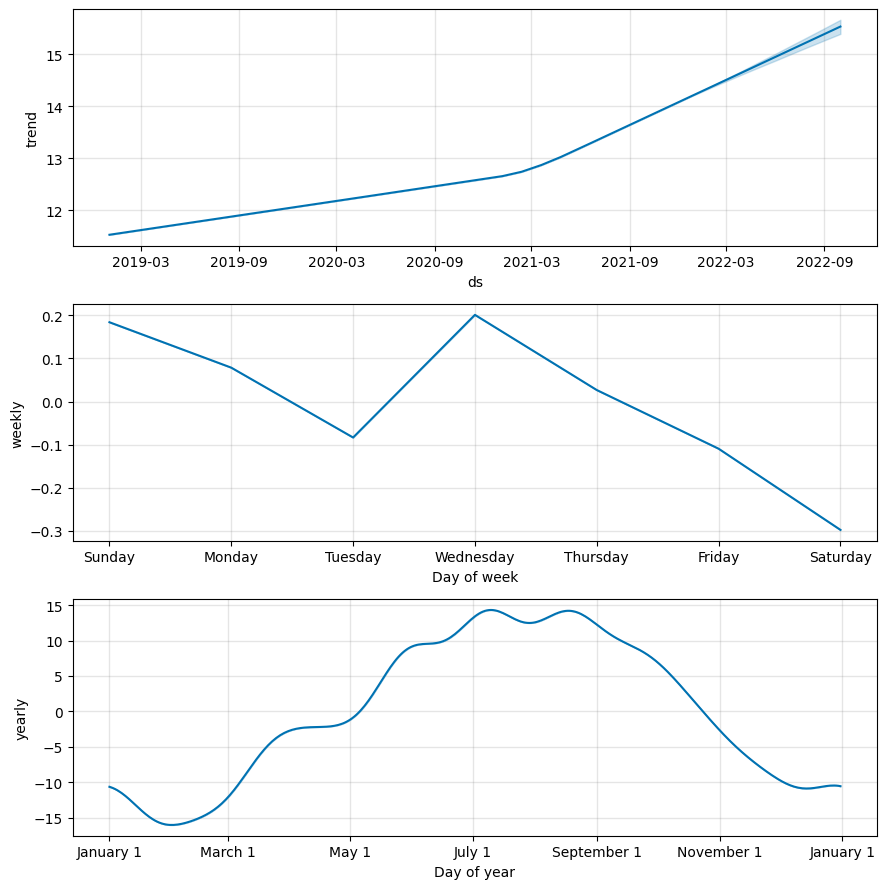

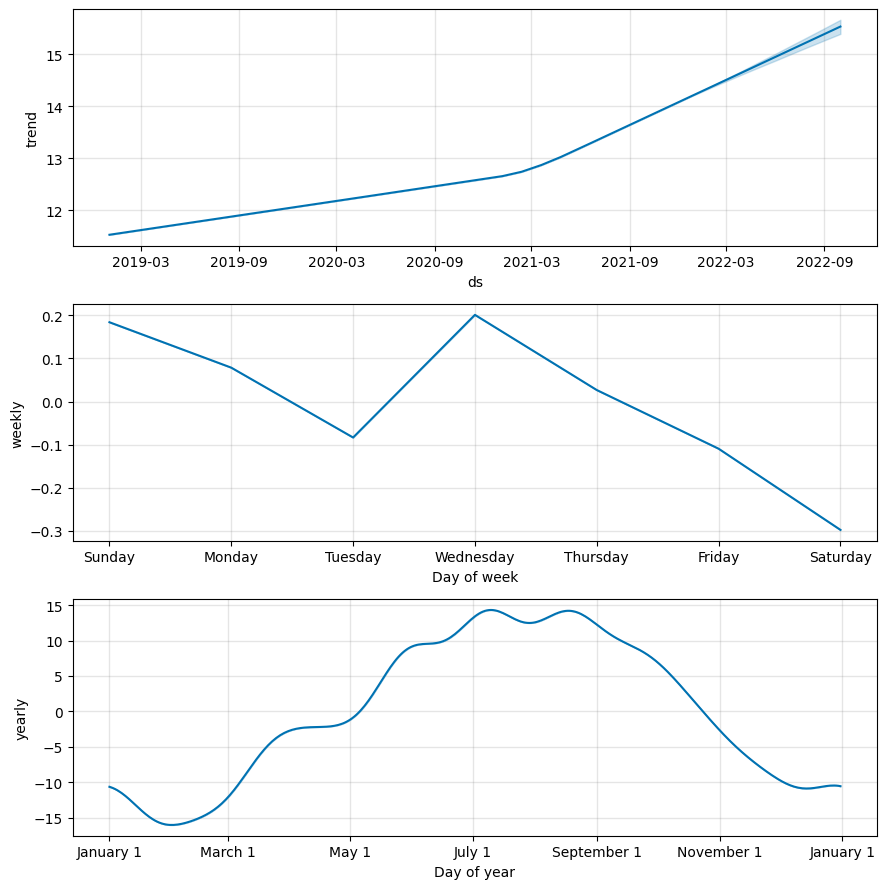

In [41]:
prophet_model.plot_components(forecast)